<a href="https://colab.research.google.com/github/ckinzthompson/removecysteines/blob/main/remove_cysteines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RemoveCysteines v0.1.4: Use ESM2 to remove cysteines from protein sequences

[Evolutionary Scale Modeling (ESM)](https://github.com/facebookresearch/esm) is a masked-large language model trained on protein sequences. The science is described in [Lin et al.](https://www.science.org/doi/10.1126/science.ade2574). Because ESM has information containing sequence conservation, we've used it here to design cys-less variants of proteins that should (ideally) maintain function. Previously, researchers would manually create a multiple sequence alignment showing the conservation of the cysteines in the wild type sequence, and then pick other amino acids that are represented at those positions.

Our approach using ESM uses the following steps:
1. Find the second-best mutation to make (i.e., whichever 'looks' most like a cysteine)
2. Make all possible point mutations, and select the best (i.e., whichever makes the entire sequence look most like a real protein)
3. Repeat step 2 until the sequence is optimized.



Label(value='Wild-type Sequence:')

Textarea(value='', layout=Layout(height='1in', width='80%'), placeholder='Enter amino acid sequence here....',…

Dropdown(description='ESM2 model:', index=3, options=('esm2_t6_8M_UR50D', 'esm2_t12_35M_UR50D', 'esm2_t30_150M…

Dropdown(description='Device:', options=('mps', 'cpu'), style=DescriptionStyle(description_width='initial'), v…

IntText(value=20, description='Maximum number of polishing steps:', style=DescriptionStyle(description_width='…

Checkbox(value=True, description='Show PCA?', style=CheckboxStyle(description_width='initial'))

Button(description='Run Optimization', style=ButtonStyle())

ESM: esm2_t33_650M_UR50D
Using Device: mps
----------
WT Sequence: MSKGEELIKENMRMKVVMEGSVNGHQFKCTGEGEGRPYEGVQVMRIKVIEGGPLPFAFDILATSFMYGSRTFIKYPADIPDFFKQSFPEGFTWERVTRYEDGGVVTVTQDTSLEDGELVYNVKVRGVNFPSNGPVMQKKTKGWEPNTEMMYPADGGLRGYTDIALKVDGGGHLHCNFVTTYRSKKTVGNIKMPGVHAVDHRLERIEESDNETYVVQREVAVAKYSNLGGGMDELYK
WT Perplexity: 42.6591987609863281
Length: 236
Num. Cys: 2
Cys locations: 29 175

---------- Optimization ----------
1. Initial MUT perplexity: 43.09578323
	C29V
	C175G
2.1 Polish, MUT perplexity 44.55866241, 4.832 sec, C29R
2.2 Polish, MUT perplexity 44.55866241, 4.604 sec, <no better change>

---------- Final ----------
MUT Sequence: MSKGEELIKENMRMKVVMEGSVNGHQFKRTGEGEGRPYEGVQVMRIKVIEGGPLPFAFDILATSFMYGSRTFIKYPADIPDFFKQSFPEGFTWERVTRYEDGGVVTVTQDTSLEDGELVYNVKVRGVNFPSNGPVMQKKTKGWEPNTEMMYPADGGLRGYTDIALKVDGGGHLHGNFVTTYRSKKTVGNIKMPGVHAVDHRLERIEESDNETYVVQREVAVAKYSNLGGGMDELYK
MUT Perplexity: 44.55866241
Mutations:
	C29R
	C175G


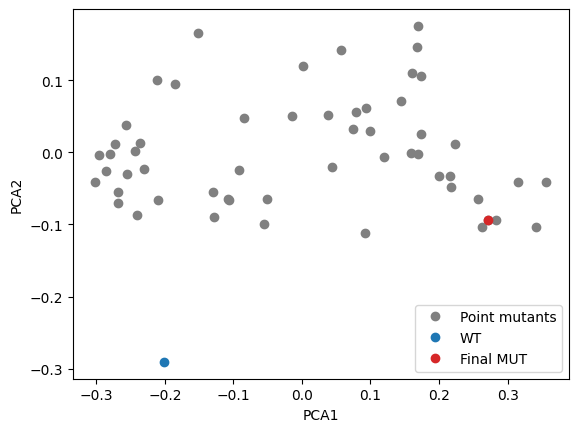

In [9]:
#@title Run this cell to setup interface

import os
import sys
import torch
import ipywidgets as widgets

try:
	import esm
except:
	os.system('pip install fair-esm')
	import esm

fdir = '/content' ## assume we're on google colab
if not os.path.exists('/content'): ## we're not on google colab
	fdir = './' ## go local

## Download remove_cysteines code
if not os.path.exists(os.path.join(fdir,'remove_cysteines.py')):
	!wget https://raw.githubusercontent.com/ckinzthompson/removecysteines/main/remove_cysteines.py -P /content

sys.path.append(fdir)
from remove_cysteines import main

ESM_models = ["esm2_t6_8M_UR50D", "esm2_t12_35M_UR50D", "esm2_t30_150M_UR50D", "esm2_t33_650M_UR50D", "esm2_t36_3B_UR50D", "esm2_t48_15B_UR50D"]

devices = []
if torch.cuda.is_available():
  devices.append('cuda')
if torch.backends.mps.is_available():
  devices.append('mps')
devices.append('cpu')

param_wt_sequence = widgets.Textarea(placeholder='Enter amino acid sequence here....', description='', layout=widgets.Layout(width='80%',height='1in'), style={'description_width':'initial'})
param_ESM_model_name = widgets.Dropdown(options=ESM_models, description='ESM2 model:', value='esm2_t33_650M_UR50D', style={'description_width':'initial'})
param_device = widgets.Dropdown(options=devices, description='Device:',style={'description_width':'initial'})
param_show_pca = widgets.Checkbox(value=True, description='Show PCA?',style={'description_width':'initial'})
param_n_rounds = widgets.IntText(value=20, description='Maximum number of polishing steps:',style={'description_width':'initial'})

display(widgets.Label(value='Wild-type Sequence:'))
display(param_wt_sequence)
display(param_ESM_model_name)
display(param_device)
display(param_n_rounds)
display(param_show_pca)

run_button = widgets.Button(description="Run Optimization")
def button_click(b):
	### Parse input widget values
	wt_sequence = param_wt_sequence.value
	ESM_model_name = param_ESM_model_name.value
	device = param_device.value
	n_rounds = param_n_rounds.value
	show_pca = param_show_pca.value
	main(wt_sequence,ESM_model_name,device,n_rounds,show_pca)
run_button.on_click(button_click)

display(run_button)